# Tutorial Plots - Preprint

In [205]:
# Make sure that the package can be imported
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import sys
from os.path import expanduser, join, split
home = expanduser("~")
sys.path.append(join(home, 'Repositories/QuREBB'))
from importlib import reload  # Python 3.4+

import numpy as np
import qutip as qt
import scipy.constants as cst
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import glob
from lib.protocol import ProtocolSweep

import h5py as h5
save_path=join(home, 'Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/')


import time
from copy import deepcopy

qt.settings.auto_tidyup = False

clr_dict = {
    'dblue': '#2596be',#'#151F30',
    'blue': '#0810b9', #'#103778',
    'lblue': '#8488dc', #'#0593A2',
    'orange': '#FF7A48',
    'dorange': '#E3371E',
    'red': '#972B17',
    'dred': '#651C0F',
    'dprl': '#952b98',
    'lprl': '#b67dd7',
    'vlprl': '#cea9e5'
    
}

In [207]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    'font.size': 12,
}

mpl.rcParams.update(params)

In [196]:
default_colors_light = ['#2596be', '#FF7A48','#972B17','#b67dd7']
default_colors_dark = ['#0810b9', '#E3371E', '#651C0F', '#952b98']

default_shades_blue = ['#4675DC', '#3B62B8', '#2E4C8F', '#213766', '#14213D']
default_shades_red = ['#DB5733', '#B8492A', '#8F3921', '#662817', '#3D180E']

## Helper Functions

In [149]:
import matplotlib.ticker as mticker
class AdditionalTickLocator(mticker.Locator):
    '''This locator chains whatever locator given to it, and then add addition custom ticks to the result'''
    def __init__(self, chain: mticker.Locator, ticks) -> None:
        super().__init__()
        assert chain is not None
        self._chain = chain
        self._additional_ticks = np.asarray(list(ticks))

    def _add_locs(self, locs):
        locs = np.unique(np.concatenate([
            np.asarray(locs),
            self._additional_ticks
        ]))
        return locs

    def tick_values(self, vmin, vmax):
        locs = self._chain.tick_values(vmin, vmax)
        return self._add_locs(locs)

    def __call__(self):
        # this will call into chain's own tick_values,
        # so we also add ours here
        locs = self._chain.__call__()
        return self._add_locs(locs)

    def nonsingular(self, v0, v1):
        return self._chain.nonsingular(v0, v1)
    def set_params(self, **kwargs):
        return self._chain.set_params(**kwargs)
    def view_limits(self, vmin, vmax):
        return self._chain.view_limits(vmin, vmax)


class AdditionalTickFormatter(mticker.Formatter):
    '''This formatter chains whatever formatter given to it, and
    then does special formatting for those passed in custom ticks'''
    def __init__(self, chain: mticker.Formatter, ticks) -> None:
        super().__init__()
        assert chain is not None
        self._chain = chain
        self._additional_ticks = ticks

    def __call__(self, x, pos=None):
        if x in self._additional_ticks:
            return self._additional_ticks[x]
        res = self._chain.__call__(x, pos)
        return res

    def format_data_short(self, value):
        if value in self._additional_ticks:
            return self.__call__(value)
        return self._chain.format_data_short(value)

    def get_offset(self):
        return self._chain.get_offset()
    
    def _set_locator(self, locator):
        self._chain._set_locator(locator)

    def set_locs(self, locs):
        self._chain.set_locs(locs)
        
def axis_add_custom_ticks(axis, ticks):
    locator = axis.get_major_locator()
    formatter = axis.get_major_formatter()
    axis.set_major_locator(AdditionalTickLocator(locator, ticks.keys()))
    axis.set_major_formatter(AdditionalTickFormatter(formatter, ticks))

def find_latest_dataset(label, save_folder):
    files = glob.glob( save_path + f"*{label}*")
    dataset_names = [split(x)[-1] for x in files]
    ds_timestamps = [datetime.strptime(x[:15], '%Y%m%d-%H%M%S') for x in dataset_names]

    sorted_idx = np.argsort(ds_timestamps)

    return join(save_folder, dataset_names[sorted_idx[-1]])

In [199]:
def plot_settings(color_idx=0):
    return {
        'color': default_colors_light[color_idx],
        'marker': '.',
        'markeredgecolor': default_colors_dark[color_idx],
        'linestyle': '--',
    }

sweep_plot_settings={
    'marker': '.',
    'linestyle': '--',
}

# Basic Params

In [83]:
file_path = find_latest_dataset("ProtocolA_fidelity_rate", save_path)
print(file_path)
dsA = xr.load_dataset(file_path)

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231010-092437-270-ProtocolA_fidelity_rate.hdf5


In [84]:
file_path = find_latest_dataset("ProtocolB_fidelity_rate", save_path)
print(file_path)
dsB = xr.load_dataset(file_path)

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231010-092455-862-ProtocolB_fidelity_rate.hdf5


In [85]:
file_path = find_latest_dataset("ProtocolC_fidelity_rate", save_path)
print(file_path)
dsC = xr.load_dataset(file_path)

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231010-092520-599-ProtocolC_fidelity_rate.hdf5


In [87]:
psA = ProtocolSweep(None, None, None)
psB = ProtocolSweep(None, None, None)
psC = ProtocolSweep(None, None, None)

In [88]:
psA.dataset = dsA
psA.generate_fidelity_rate_curve()

psB.dataset = dsB
psB.generate_fidelity_rate_curve()

psC.dataset = dsC
psC.generate_fidelity_rate_curve()

In [115]:
dub_col = (2 * 246 + 18) / 72
fig_height = 0.6 * dub_col

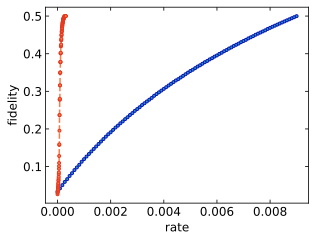

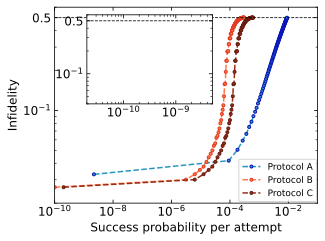

In [280]:
fig, ax = plt.subplots(figsize = (2/3*dub_col,1/2*dub_col))

figname = 'protocols_comparison_v5_1'

(1-psA.dataset_fidelity_rate.fidelity).plot(ax=ax, label='Protocol A', **plot_settings(0))
(1-psB.dataset_fidelity_rate.fidelity).plot(ax=ax, label='Protocol B', **plot_settings(1))
(1-psC.dataset_fidelity_rate.fidelity).plot(ax=ax, label='Protocol C', **plot_settings(2))

#rf_ax.scatter(lr_rcurve[10], lr_fcurve[10], s=200, marker='+', color='k', linewidth=1.5)

ax.set_xscale('log')
ax.set_yscale('log')



ax.hlines(0.5, 1e-15,0.1, 'k', linestyle = '--', linewidth = 0.8)

ax.set_ylim(2e-2,0.6)
ax.set_xlim(1e-10,1e-1)
ax.set_xlabel("Success probability per attempt")
ax.set_ylabel("Infidelity")

left, bottom, width, height = [0.22, 0.5, 0.37, 0.35]
wcs_ax = fig.add_axes([left, bottom, width, height])
wcs_ax.set_xscale('log')
wcs_ax.set_yscale('log')
wcs_ax.set_ylim(4e-2,0.6)
wcs_ax.set_xlim(2e-11,5e-9)
wcs_ax.hlines(0.5, 1e-12,0.1, 'k', linestyle = '--', linewidth = 0.8)


fig.legend(loc=1, bbox_to_anchor=(0.91, 0.3), fontsize=9)


axis_add_custom_ticks(ax.yaxis, {
    0.5: '0.5'
})

axis_add_custom_ticks(wcs_ax.yaxis, {
    0.5: '0.5'
})

plt.show()


# Coop sweep

## sweeping kappa

In [178]:
name = "CoopSweepKappa"

coops = [1, 10, 50, 500]

In [179]:
dsk = {}

for c in coops:
    fname = find_latest_dataset(name+f"_C{c}.", save_path)
    print(fname)
    d = xr.load_dataset(fname)

    ps = ProtocolSweep(None, None, None)
    ps.dataset = d
    ps.generate_fidelity_rate_curve()
    
    dsk.update({str(c): ps.dataset_fidelity_rate})

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-110354-722-CoopSweepKappa_C1.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-120057-476-CoopSweepKappa_C10.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-125745-346-CoopSweepKappa_C50.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-154755-167-CoopSweepKappa_C500.hdf5


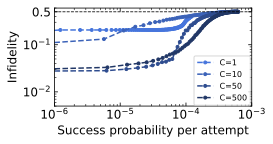

In [277]:
fig, ax = plt.subplots(figsize=(1/2*dub_col, 1/4*dub_col))

i=0
for key, el in dsk.items():
    (1-el.fidelity).plot(ax=ax, label = f"C={key}", color=default_shades_blue[i], **sweep_plot_settings)
    i+=1

ax.set_xscale('log')
ax.set_yscale('log')

ax.hlines(0.5, 1e-15,0.1, 'k', linestyle = '--', linewidth = 0.8)

ax.set_ylim(5e-3,0.6)
ax.set_xlim(1e-6,1e-3)
ax.set_xlabel("Success probability per attempt")
ax.set_ylabel("Infidelity")

fig.legend(loc=1, bbox_to_anchor=(0.91, 0.535), fontsize=8)


axis_add_custom_ticks(ax.yaxis, {
    0.5: '0.5'
})

axis_add_custom_ticks(wcs_ax.yaxis, {
    0.5: '0.5'
})

plt.show()

In [181]:
name = "CoopSweepG"

coops = [1, 10, 50, 500]

In [182]:
dsg = {}

for c in coops:
    fname = find_latest_dataset(name+f"_C{c}.", save_path)
    print(fname)
    d = xr.load_dataset(fname)

    ps = ProtocolSweep(None, None, None)
    ps.dataset = d
    ps.generate_fidelity_rate_curve()
    
    dsg.update({str(c): ps.dataset_fidelity_rate})

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231012-233440-826-CoopSweepG_C1.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-004237-616-CoopSweepG_C10.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-015030-948-CoopSweepG_C50.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-051444-745-CoopSweepG_C500.hdf5


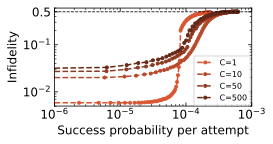

In [276]:
fig, ax = plt.subplots(figsize=(1/2*dub_col, 1/4*dub_col))

i=0
for key, el in dsg.items():
    (1-el.fidelity).plot(ax=ax, label = f"C={key}", color = default_shades_red[i], **sweep_plot_settings)
    i +=1

ax.set_xscale('log')
ax.set_yscale('log')

ax.hlines(0.5, 1e-15,0.1, 'k', linestyle = '--', linewidth = 0.8)

ax.set_ylim(5e-3,0.6)
ax.set_xlim(1e-6,1e-3)
ax.set_xlabel("Success probability per attempt")
ax.set_ylabel("Infidelity")

fig.legend(loc=1, bbox_to_anchor=(0.91, 0.535), fontsize=8)


axis_add_custom_ticks(ax.yaxis, {
    0.5: '0.5'
})

axis_add_custom_ticks(wcs_ax.yaxis, {
    0.5: '0.5'
})

plt.show()

In [249]:
float(dsg["1"].sel(rate=1e-5, method='nearest').fidelity.values)

0.9941265053533173

In [273]:
coops = [1, 10, 50, 100, 200, 500, 1000]

lowrate = 1e-5
hirate=1e-4

max_lowrate_kappa = []
max_lowrate_g = []

max_hirate_kappa = []
max_hirate_g = []

for c in coops:
    fname = find_latest_dataset("CoopSweepG"+f"_C{c}.", save_path)
    print(fname)
    d = xr.load_dataset(fname)

    ps = ProtocolSweep(None, None, None)
    ps.dataset = d
    ps.generate_fidelity_rate_curve()

    max_lowrate_g.append( float(ps.dataset_fidelity_rate.sel(rate=lowrate, method='nearest').fidelity.values) )
    max_hirate_g.append(  float(ps.dataset_fidelity_rate.sel(rate=hirate, method='nearest').fidelity.values) )

    fname = find_latest_dataset("CoopSweepKappa"+f"_C{c}.", save_path)
    print(fname)
    d = xr.load_dataset(fname)

    ps = ProtocolSweep(None, None, None)
    ps.dataset = d
    ps.generate_fidelity_rate_curve()

    max_lowrate_kappa.append( float(ps.dataset_fidelity_rate.sel(rate=lowrate, method='nearest').fidelity.values) )
    max_hirate_kappa.append(  float(ps.dataset_fidelity_rate.sel(rate=hirate, method='nearest').fidelity.values) )

C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231012-233440-826-CoopSweepG_C1.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-110354-722-CoopSweepKappa_C1.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-004237-616-CoopSweepG_C10.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-120057-476-CoopSweepKappa_C10.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-015030-948-CoopSweepG_C50.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231011-125745-346-CoopSweepKappa_C50.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/tutorial_simulations/notebooks/simulations_preprint/20231013-025832-004-CoopSweepG_C100.hdf5
C:\Users\Matteo Pasini\Repositories/QuREBB/t

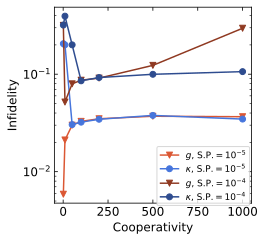

In [281]:
fig, ax = plt.subplots(figsize=(1/2*dub_col, 1/2*dub_col))

ax.plot(coops, 1-np.array(max_lowrate_g), label = r"$g$, S.P.$=10^{-5}$", color=default_shades_red[0], marker='v')
ax.plot(coops, 1-np.array(max_lowrate_kappa), label = r"$\kappa$, S.P.$=10^{-5}$", color=default_shades_blue[0], marker='o')

ax.plot(coops, 1-np.array(max_hirate_g), label = r"$g$, S.P.$=10^{-4}$", color=default_shades_red[2], marker='v')
ax.plot(coops, 1-np.array(max_hirate_kappa), label = r"$\kappa$, S.P.$=10^{-4}$", color=default_shades_blue[2], marker='o')

ax.set_yscale('log')
ax.set_ylabel('Infidelity')

ax.set_xlabel("Cooperativity")

fig.legend(loc=1, bbox_to_anchor=(0.91, 0.35), fontsize=9)
plt.show()